At the present moment, the dominant models for nearly all natural language processing tasks are based on the Transformer architecture. Given any new task in natural language processing, the default first-pass approach is to grab a large Transformer-based pretrained model, (e.g., BERT (Devlin et al., 2018), ELECTRA (Clark et al., 2020), RoBERTa (Liu et al., 2019), or Longformer (Beltagy et al., 2020)) adapting the output layers as necessary, and fine-tuning the model on the available data for the downstream task.

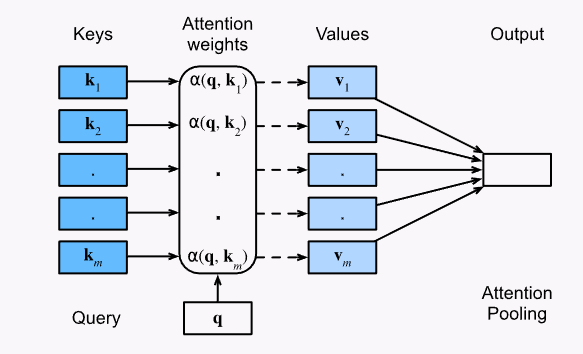

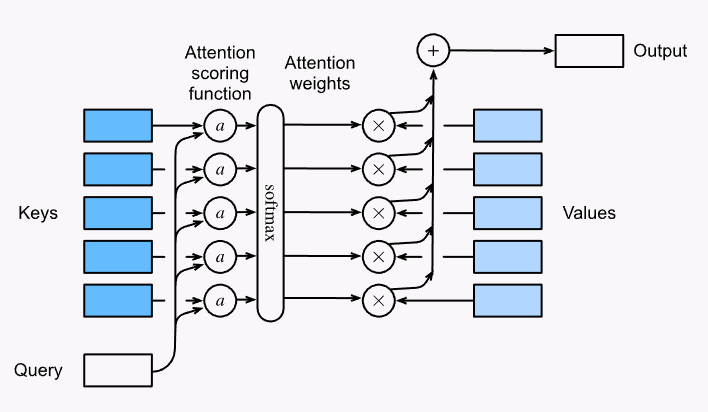

- Key: the dictionary input
- Value: the dictionary output
- Querey: attention weight per key

In [7]:
import numpy as np
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

d2l.use_svg_display()

In [6]:
def show_heatmaps(matrices, xlabel, ylabel, titles=None, figsize=(2.5, 2.5), cmap='Reds'):
    """Show heatmaps of the given matrices."""
    d2l.use_svg_display()
    num_rows, num_cols, _, _ = matrices.shape
    fig, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize, sharex=True, sharey=True, squeeze=False)
    for i, (row_axes, row_matrices) in enumerate(zip(axes, matrices)):
        for j, (ax, matrix) in enumerate(zip(row_axes, row_matrices)):
            pcm = ax.imshow(matrix.detach().numpy(), cmap=cmap)
            if i == num_rows - 1:
                ax.set_xlabel(xlabel)
            if j == 0:
                ax.set_ylabel(ylabel)
            if titles:
                ax.set_title(titles[j])
    fig.colorbar(pcm, ax=row_axes, shrink=0.6)

In [ ]:
def masked_softmax(X, valid_lens):  #@save
    """Perform softmax operation by masking elements on the last axis."""
    # X: 3D tensor, valid_lens: 1D or 2D tensor
    def _sequence_mask(X, valid_len, value=0):
        maxlen = X.size(1)
        mask = torch.arange((maxlen), dtype=torch.float32,
                            device=X.device)[None, :] < valid_len[:, None]
        X[~mask] = value
        return X

    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        # On the last axis, replace masked elements with a very large negative
        # value, whose exponentiation outputs 0
        X = _sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

# valid_lens determines the rows of elements to masked in the last axis, manipulated the other randomly generated numbers to sum up to 1 properly
# Ultimately reshapes the model tensors to only attend to valid past tokens

#### Scaled dot-product attention

In [ ]:
class DotProductAttention(nn.Module):
    """Scaled dot-product attention"""
    def __init()__(self, dropout):
        super().__init__()
        self.dropout = nn.Dropout(dropout)

    # Shape of queries: (batch_size, no. of queries, d)
    # Shape of keys: (batch_size, no. of key-value pairs, d)
    # Shape of values: (batch_size, no. of key-value pairs, value dimension)
    # Shape of valid_lens: (batch_size,) or (batch_size, no. of queries)
    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]
        # Swap the last two dimensions of keys with keys.transpose(1, 2)
        scores = torch.bmm(queries, keys.transpose(1, 2)) / math.sqrt(d)
        attention_weights = masked_softmax(scores, valid_lens)
        return torch.bmm(self.dropout(attention_weights), values)